In [3]:
import os
import torch

from diffusers import StableDiffusionXLPipeline, DDIMScheduler
from consistentSA.consistentSA import SpatialAttnProcessor2_0, set_attention_processor, setup_seed
from consistentSA.style_desc_template import styles

/root/miniconda3/envs/2024-confer/lib/python3.8/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [4]:
device = torch.device("cuda")
# pipe = StableDiffusionXLPipeline.from_pretrained("Linaqruf/sketch-style-xl-lora", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe = StableDiffusionXLPipeline.from_pretrained("Linaqruf/animagine-xl-2.0", torch_dtype=torch.float16)
pipe.load_lora_weights("Linaqruf/sketch-style-xl-lora")
# pipe.fuse_lora(lora_scale=0.6)
pipe = pipe.to(device)
# pipe.enable_freeu(s1=0.6, s2=0.4, b1=1.1, b2=1.2)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(50)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
pipe.dtype

torch.float16

In [16]:
# 생성할 character ID image 갯수
id_length = 1
total_count = set_attention_processor(pipe.unet, id_length=id_length, sa32=0.5, sa64=0.5)
print("Total Consistent Attention count:", total_count)

Total Consistent Attention count: 36


Style prompt template

In [6]:
STYLE_NAMES = list(styles.keys())
DEFAULT_STYLE_NAME = "(No style)"
print("Available style template:", STYLE_NAMES)

def apply_style_prompt_positive(style_name: str, positive_prompt: str):
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return p.replace("{prompt}", positive_prompt) 
def apply_style_prompt(style_name: str, positive_prompts: list, negative_prompt: str = ""):
    p, n = styles.get(style_name, styles[DEFAULT_STYLE_NAME])
    return [p.replace("{prompt}", positive) for positive in positive_prompts], n + ' ' + negative_prompt

Available style template: ['(No style)', 'Japanese Anime', 'Digital/Oil Painting', 'Pixar/Disney Character', 'Photographic', 'Comic book', 'Line art', 'Black and White Film Noir', 'Isometric Rooms']


Prompts setting

In [10]:
general_prompt = "girl, sketch"
negative_prompt = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
prompt_array = ["wake up in the bed",
                "have breakfast",
                "is on the road, go to the company",
                "work in the company",
                "running in the playground",
                "reading book in the home"
                ]

prompts = [general_prompt+","+prompt for prompt in prompt_array]
id_prompts = prompts[:id_length]
real_prompts = prompts[id_length:]

print("ID image prompts:", id_prompts)
print("Consequent Image prompts:", real_prompts)

ID image prompts: ['girl, sketch,wake up in the bed']
Consequent Image prompts: ['girl, sketch,have breakfast', 'girl, sketch,is on the road, go to the company', 'girl, sketch,work in the company', 'girl, sketch,running in the playground', 'girl, sketch,reading book in the home']


ID Image Generation

Positive prompt: ['girl, sketch,wake up in the bed']
Negative prompt: lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry


  0%|          | 0/50 [00:00<?, ?it/s]

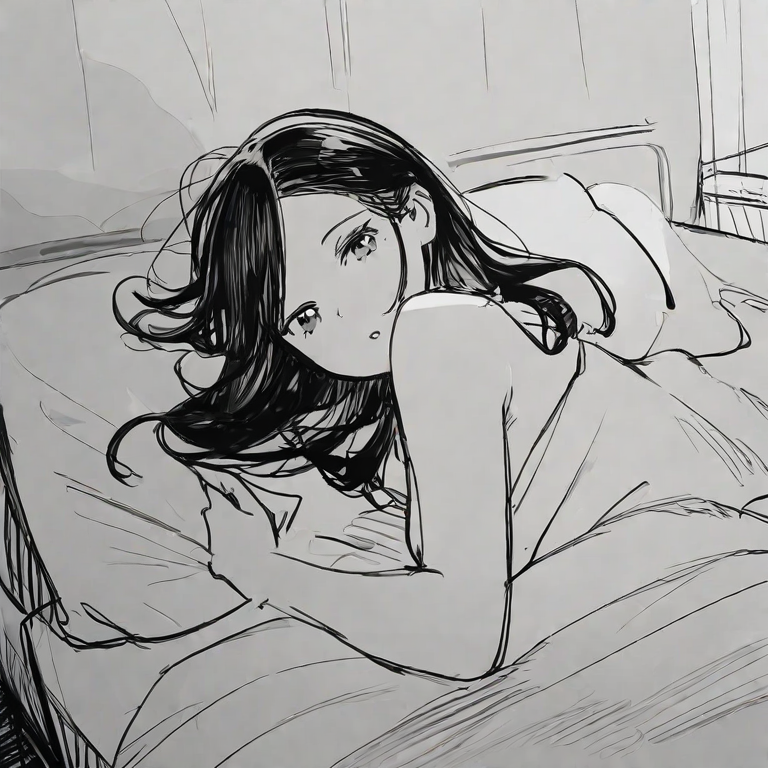

In [17]:
seed = 2023
setup_seed(seed)
generator = torch.Generator(device="cuda").manual_seed(seed)
SpatialAttnProcessor2_0.set_write()

style = "Comic book"
# prompt_positive, prompt_negative = apply_style_prompt(style, id_prompts, negative_prompt)
prompt_positive = id_prompts
prompt_negative = negative_prompt

print("Positive prompt:", prompt_positive)
print("Negative prompt:", prompt_negative)

SpatialAttnProcessor2_0.reset()
id_images = pipe(prompt_positive, num_inference_steps = 50, guidance_scale=5.0, height = 768, width = 768,negative_prompt = prompt_negative, generator = generator).images

for id_image in id_images:
    display(id_image)

Consequent Generations

Positive prompt: girl, sketch,have breakfast
Negative prompt: lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry


  0%|          | 0/50 [00:00<?, ?it/s]

Positive prompt: girl, sketch,is on the road, go to the company
Negative prompt: lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry


  0%|          | 0/50 [00:00<?, ?it/s]

Positive prompt: girl, sketch,work in the company
Negative prompt: lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry


  0%|          | 0/50 [00:00<?, ?it/s]

Positive prompt: girl, sketch,running in the playground
Negative prompt: lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry


  0%|          | 0/50 [00:00<?, ?it/s]

Positive prompt: girl, sketch,reading book in the home
Negative prompt: lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry


  0%|          | 0/50 [00:00<?, ?it/s]

girl, sketch,have breakfast


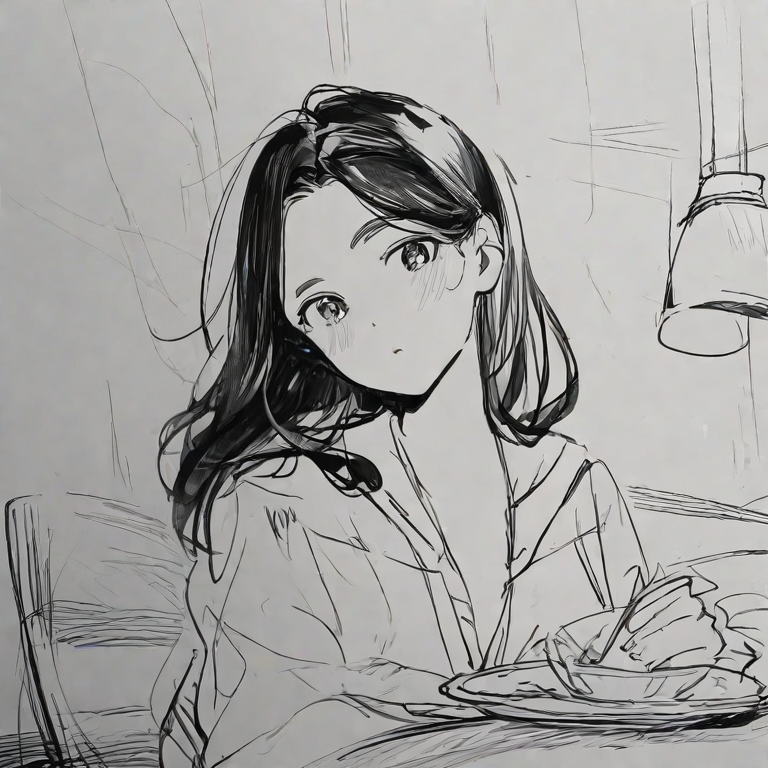

girl, sketch,is on the road, go to the company


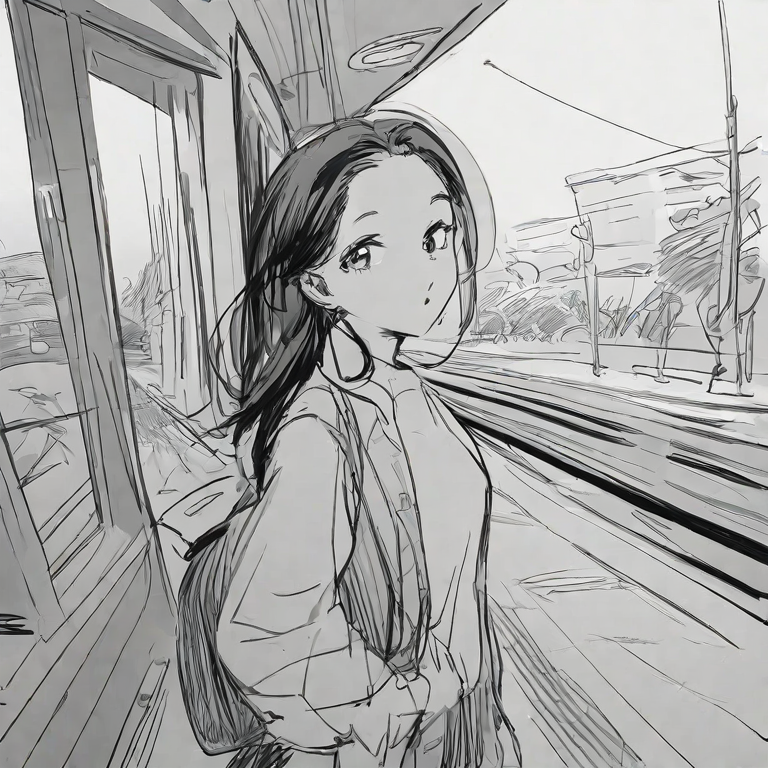

girl, sketch,work in the company


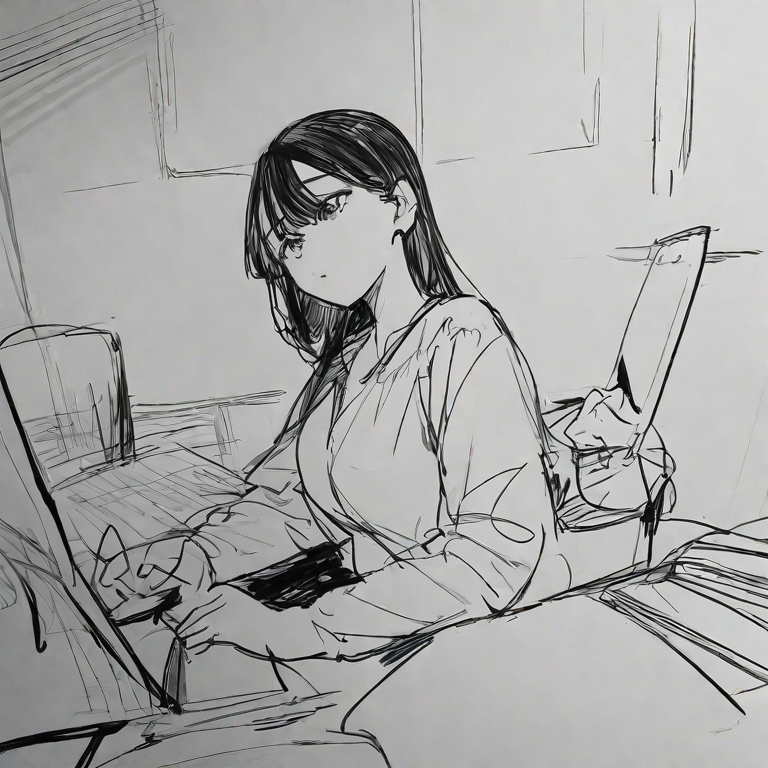

girl, sketch,running in the playground


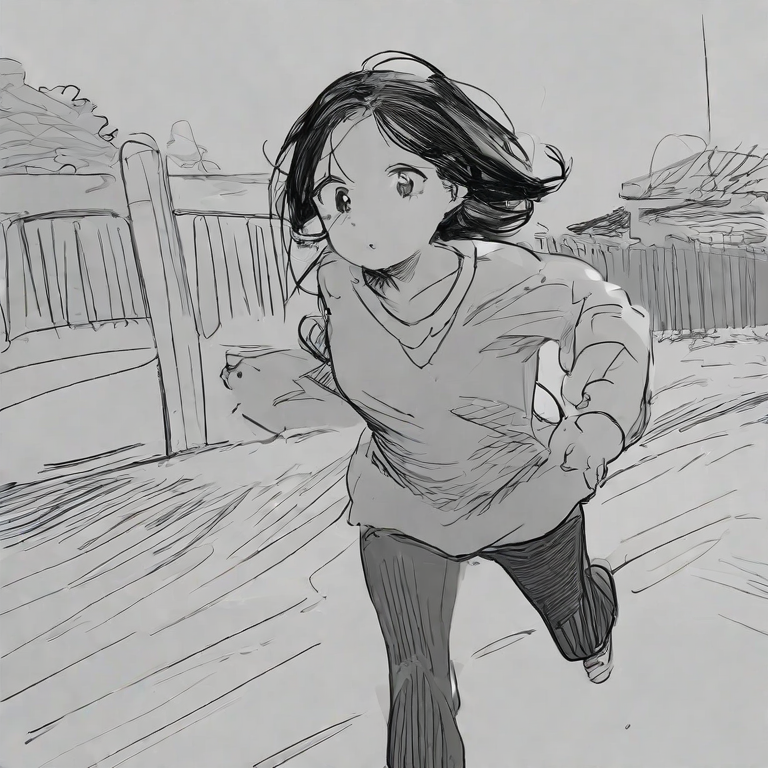

girl, sketch,reading book in the home


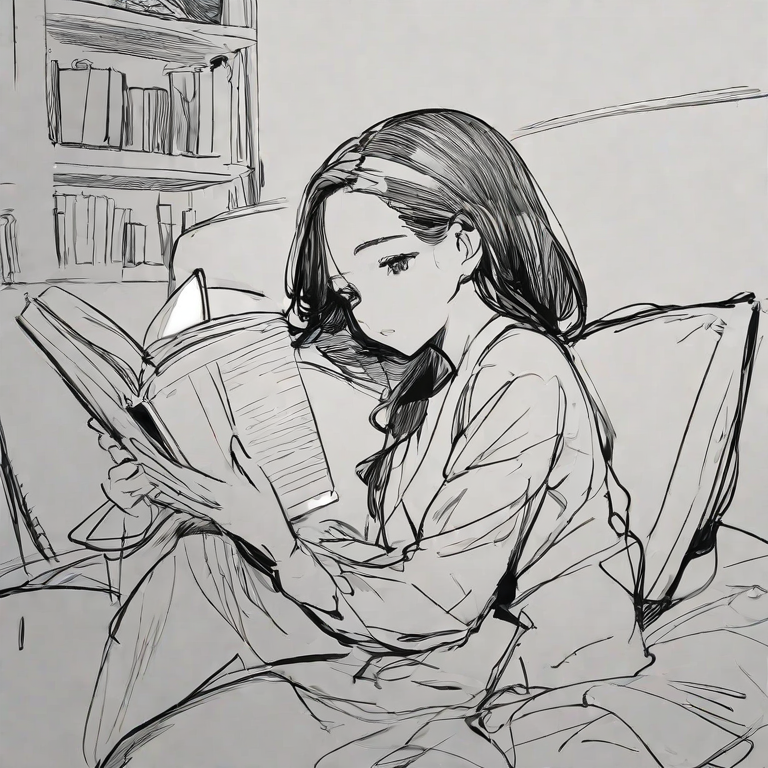

In [19]:
seed = 2023
setup_seed(seed)
generator = torch.Generator(device="cuda").manual_seed(seed)
SpatialAttnProcessor2_0.unset_write()

real_images = []
for real_prompt in real_prompts:
    # prompt_positive = apply_style_prompt_positive(style, real_prompt)
    prompt_positive = real_prompt
    prompt_negative = negative_prompt
    
    print("Positive prompt:", prompt_positive)
    print("Negative prompt:", prompt_negative)
    
    SpatialAttnProcessor2_0.reset()
    real_images.append(pipe(real_prompt,  num_inference_steps=50, guidance_scale=5.0,  height = 768, width = 768,negative_prompt = prompt_negative,generator = generator).images[0])

for prompt, real_image in zip(real_prompts, real_images):
    print(prompt)
    display(real_image)  